# 网络生成与更改

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
# 'serif', 'sans-serif', 'monospace', 'fantasy', 'cursive'
cnFont = {'fontname':'Songti SC', 'color':'darkred', 'weight':'bold', 'size': 30}
# plt.rcParams['figure.dpi'] = 400
import seaborn as sns
import scienceplots
import numpy as np
from scipy import stats
from scipy import optimize
import pandas as pd
from pandas import Series,DataFrame
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

import networkx as nx
from networkx.utils import powerlaw_sequence
import powerlaw

from lib.utils import *

## 生成符合幂律分布的度序列

In [2]:
degree_seq = powerlaw_sequence(10000, exponent=2.5)
int_deg = [int(di) for di in degree_seq]
# print(int_deg)

In [3]:
fit = powerlaw.Fit(int_deg)
print(fit)
kmin = fit.power_law.xmin
print("kmin:", kmin)
print("gamma:", fit.power_law.alpha)
print("D:", fit.power_law.D)

Calculating best minimal value for power law fit
kmin: 17.0
gamma: 2.5724695025187594
D: 0.0392927241035097


<AxesSubplot: >

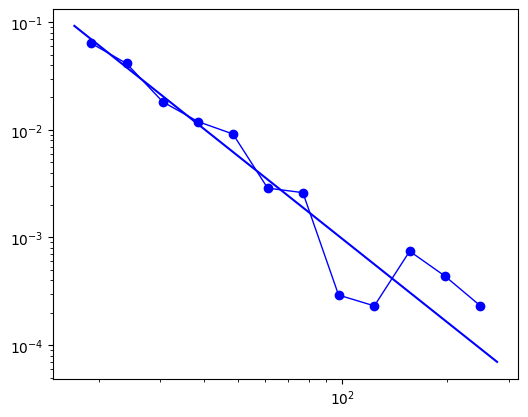

In [4]:
plt.figure(figsize=[6, 4.8])
fig = fit.plot_pdf(marker = 'o', color='b', linewidth=1)
fit.power_law.plot_pdf(color='b', linestyle='-', ax=fig)

## 1、配置模型生成给定度序列的网络

In [5]:
n, gamma = 5000, 2.1
degree_seq = powerlaw_sequence(n, gamma)
int_deg = [int(di) for di in degree_seq]

while sum(int_deg)%2 != 0:
    degree_seq = powerlaw_sequence(n, gamma)
    int_deg = [int(di) for di in degree_seq]
    
    
G = nx.configuration_model(int_deg)
# 该模型会生成自环和多重链接，而这些在真实网络中通常是不会出现的
for e in G.edges():
    if e[0]==e[1]:
        # print(e)
        pass

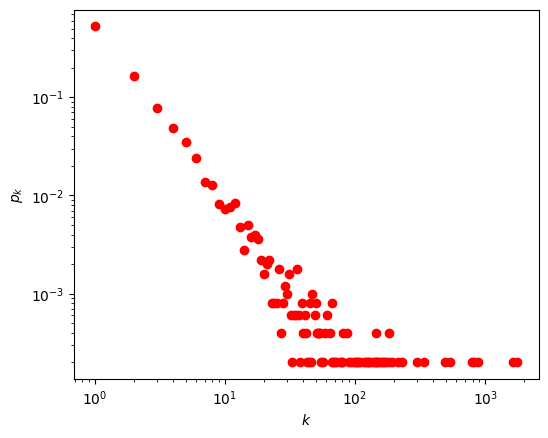

In [6]:
k, Pk = get_pdf(G)
plt.figure(figsize=(6,4.8))
plt.plot(k, Pk, 'ro')
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.xscale("log")
plt.yscale("log")

**总结**：配置模型会生成自环和重连边，而这些在真实网络中通常是不会出现的。生成的网络的平均度会随着幂律指数的改变而变化，即平均度不可控

## 2、隐参数模型生成给定度分布指数的无标度网络

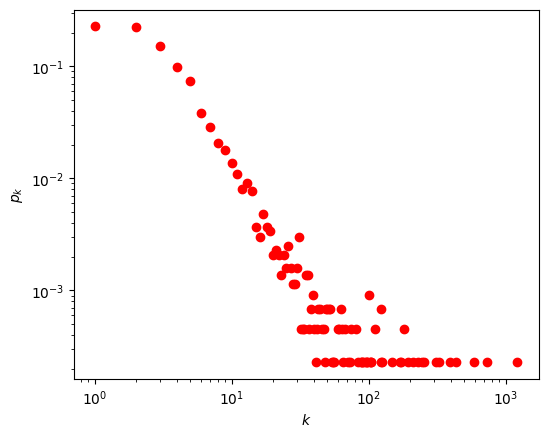

In [7]:
N = 5000
gamma = 2.1
avk = 6.0
L = int(avk*N/2)

G = generate_SF_network(N, gamma, L)
k, Pk = get_pdf(G)
plt.figure(figsize=(6, 4.8))
plt.plot(k, Pk, 'ro')
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.xscale("log")
plt.yscale("log")

## 3、度保持的网络随机化

In [8]:
# 加载蛋白质网络数据集
df = pd.read_csv("data/protein_interaction.edgelist.csv")
G = nx.from_pandas_edgelist(df, 'source', 'target', create_using = nx.Graph())
print(len(G.nodes()), len(G.edges()))

2018 2930


In [9]:
# 删除self-loops
self_edges = []
for e in G.edges():
    if e[0]==e[1]:
        self_edges.append(e)
G.remove_edges_from(self_edges)

Gcc = sorted(nx.connected_components(G), key=len, reverse=True) 
# 得到图G的最大连通组件
LCC = G.subgraph(Gcc[0])

# 获取原始网络的最大连通子图节点数和连边数
N, M = len(LCC.nodes), len(LCC.edges())
print(N, M)
# nx.draw(LCC, pos=nx.kamada_kawai_layout(LCC), node_size=30, node_color="red")

1647 2518


In [10]:
print(nx.average_clustering(LCC))

# 生成度保持的随机化网络：调用double_edge_swap函数
newG = LCC.copy()
G_d = nx.double_edge_swap(newG, nswap=M, max_tries=5*M)
print(nx.average_clustering(G_d))
# nx.draw(G_d, pos=nx.kamada_kawai_layout(G_d), node_size=30, node_color="red")

0.05659957171711166
0.009327603388905106


In [11]:
# 生成完全随机化的网络
G_r = nx.gnm_random_graph(N, M)

### 测试小世界性质

Text(0, 0.5, '$p_d$')

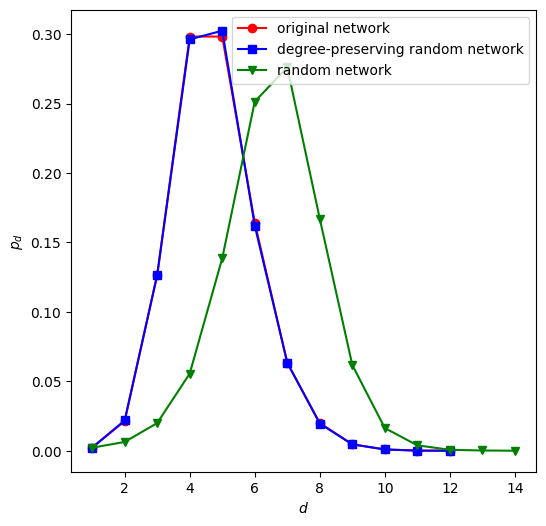

In [12]:
all_sp1, Pl = get_pdf_spl(newG)
all_sp1_d, Pl_d = get_pdf_spl(G_d)
all_sp1_r, Pl_r = get_pdf_spl(G_r)
plt.figure(figsize=(6,6))
plt.plot(all_sp1, Pl, 'ro-', label='original network')
plt.plot(all_sp1_d, Pl_d, 'bs-', label='degree-preserving random network')
plt.plot(all_sp1_r, Pl_r, 'gv-', label='random network')
plt.legend(loc=0)
plt.xlabel("$d$")
plt.ylabel("$p_d$")

In [13]:
print(nx.is_connected(LCC))
print(nx.is_connected(G_d))

True
False


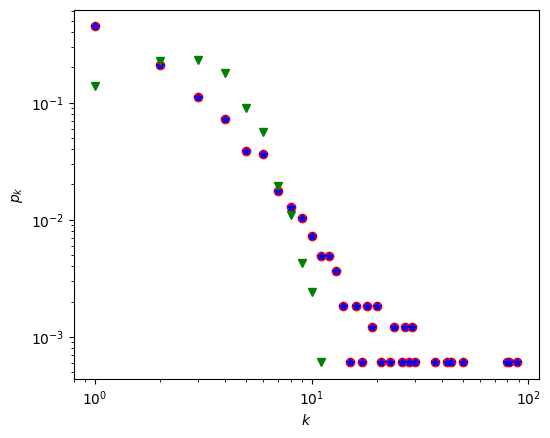

In [14]:
k1, Pk1 = get_pdf(LCC)
k2, Pk2 = get_pdf(G_d)
k3, Pk3 = get_pdf(G_r)
plt.figure(figsize=(6, 4.8))
plt.plot(k1, Pk1, 'ro')
plt.plot(k2, Pk2, 'b*')
plt.plot(k3, Pk3, 'gv')
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.xscale("log")
plt.yscale("log")